Data Pre Processing


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"EasyVisa.csv")
# Print shape of dataset
print(df.shape)

(25480, 12)


Data Cleaning

Handling Missing values

Handling Missing values

Handling Duplicates

Check data type

Understand the dataset

Check Null Values

In [3]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

In [4]:
features_with_na

[]

There are no null values in the dataset

Other Data Cleaning steps

Handling Duplicates

In [5]:
df.duplicated().sum()

0

no duplicates in dataset

Remove case_id from the dataset as it cannot used in Model Training

In [6]:
df.drop('case_id', inplace=True, axis=1)

Feature engineering

Feature Extraction

In [7]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [8]:
# importing date class from datetime module
from datetime import date
  
# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

In [9]:
current_year

2025

Subtract current year with year of estab to get company's age

In [10]:
df['company_age'] = current_year-df['yr_of_estab']

In [11]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


In [12]:
df.drop('yr_of_estab', inplace=True, axis=1)

Type of Features

Numeric Features

In [13]:

num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 3



Categorical Features

In [14]:
cat_features = [feature for feature in df.columns if df[feature].dtype == '0']
print('Num of Categorical Features :' , len(cat_features))

Num of Categorical Features : 0


Discrete Features

In [15]:
discrete_features = [feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete features : ', len(discrete_features))

Num of Discrete features :  0


Continuous Features

In [17]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features : ',len(continuous_features))

Num of Continuous Features :  3


Split X and Y

Split Dataframe to X and y

Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “Case_Status” column.

In [18]:
X = df.drop('case_status', axis=1)
y = df['case_status']

In [19]:
y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

Manual Encoding target column

In [27]:
# If the target column has Denied it is encoded as 1 others as 0
y= np.where(y=='Denied', 1,0)

In [28]:
y

array(0)

Feature Transformation

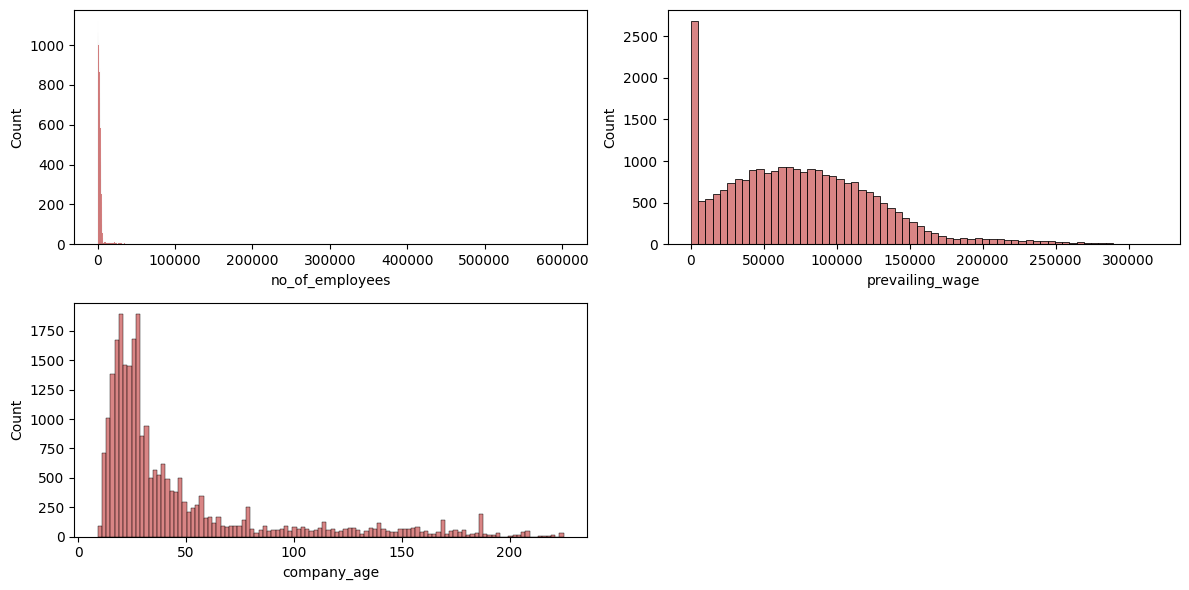

In [29]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()


No of employees and Copmany age column is skewed
Apply a power transform featurewise to make data more Gaussian-like.
Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

Apply Power Transformer to Check if it can reduces the outliers

In [30]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [32]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

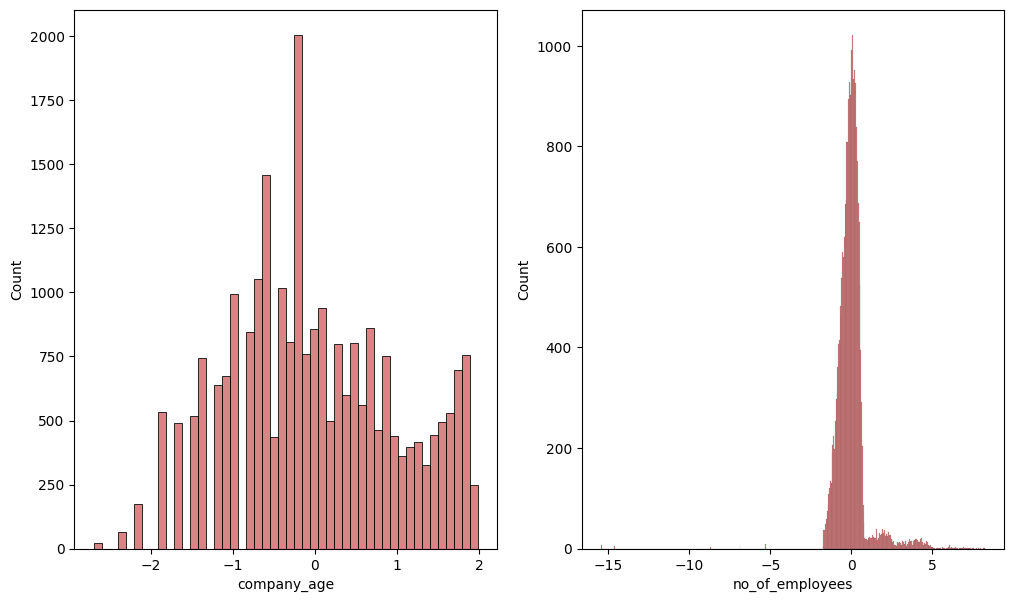

In [41]:
plt.figure(figsize=(12,7))
for i, col in enumerate(transform_features):
  plt.subplot(1, 2, i+1)
  sns.histplot(x=X_copy[col], color='indianred')
  plt.xlabel(col)
  plt.tight_layout


Checking Skewness

In [42]:
X_copy.skew(axis=0, skipna=True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
So Power Transformer with yeo-johnson can be used.

In [47]:
for feature in cat_features:
    print(feature,':', df[feature].nunique())

In [48]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [49]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']


Preprocessing using Column Transformer

In [58]:
# Create Column Transformer with 3 types of transformers
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']


from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)
